# Estatísticas dos Vídeos de Sutura Cirúrgica

Este notebook realiza uma análise estatística detalhada dos vídeos do dataset, explorando propriedades como duração, resolução, taxa de quadros, e outras características técnicas e visuais relevantes.

## Objetivos
- Calcular estatísticas técnicas dos vídeos (resolução, duração, FPS, etc.)
- Analisar distribuições de características visuais (brilho, contraste, movimento)
- Identificar outliers e padrões nos dados
- Gerar visualizações informativas para entender melhor o dataset

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import time

sns.set_palette("muted")
%matplotlib inline

## 1. Coleta de Estatísticas Técnicas

Vamos coletar informações técnicas de todos os vídeos no dataset.

In [2]:
dataset_path = "../../dataset"

video_files = glob.glob(os.path.join(dataset_path, "**/*.mp4"), recursive=True)
print(f"Total de vídeos encontrados: {len(video_files)}")

def get_video_stats(video_path):
    """Extrai estatísticas técnicas de um vídeo"""
    try:
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            return None
        
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0
        
        fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
        codec = "".join([chr((fourcc >> 8 * i) & 0xFF) for i in range(4)])
        
        file_size_mb = os.path.getsize(video_path) / (1024 * 1024)
        
        brightness_samples = []
        contrast_samples = []
        
        sample_points = np.linspace(0, frame_count-1, 10, dtype=int) if frame_count > 10 else range(frame_count)
        
        for frame_idx in sample_points:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if ret:
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                brightness = np.mean(gray)
                contrast = np.std(gray)
                
                brightness_samples.append(brightness)
                contrast_samples.append(contrast)
        
        cap.release()
        
        return {
            'filename': os.path.basename(video_path),
            'path': os.path.relpath(video_path, dataset_path),
            'width': width,
            'height': height,
            'resolution': f"{width}x{height}",
            'fps': fps,
            'frame_count': frame_count,
            'duration_sec': duration,
            'codec': codec,
            'file_size_mb': file_size_mb,
            'avg_brightness': np.mean(brightness_samples) if brightness_samples else None,
            'avg_contrast': np.mean(contrast_samples) if contrast_samples else None,
            'bitrate_mbps': (file_size_mb * 8) / duration if duration > 0 else None
        }
    except Exception as e:
        print(f"Erro ao processar {video_path}: {e}")
        return None

print("A calcular estatísticas dos vídeos...")
start_time = time.time()

video_stats = []
with ThreadPoolExecutor(max_workers=4) as executor:
    for result in tqdm(executor.map(get_video_stats, video_files), total=len(video_files)):
        if result:
            video_stats.append(result)

print(f"Tempo de processamento: {time.time() - start_time:.2f} segundos")
print(f"Estatísticas colecionadas para {len(video_stats)} vídeos")

stats_df = pd.DataFrame(video_stats)
stats_df.head()

Total de vídeos encontrados: 30
A calcular estatísticas dos vídeos...


  0%|          | 0/30 [00:00<?, ?it/s]

Tempo de processamento: 15.26 segundos
Estatísticas colecionadas para 30 vídeos


,filename,path,width,height,resolution,fps,frame_count,duration_sec,codec,file_size_mb,avg_brightness,avg_contrast,bitrate_mbps
0,A88O.mp4,A88O.mp4,1920,1080,1920x1080,29.973154,9597,320.186526,h264,374.145091,116.487836,49.719536,9.348178
1,A80U.mp4,A80U.mp4,1920,1080,1920x1080,29.973304,9157,305.505196,h264,265.204862,129.055796,40.845884,6.944690
2,A40E.mp4,A40E.mp4,1920,1080,1920x1080,29.973310,9140,304.937964,h264,260.644066,115.957257,52.920549,6.837956
3,A99X.mp4,A99X.mp4,1920,1080,1920x1080,29.973324,9100,303.603294,h264,330.473669,116.857706,50.820947,8.708039
4,B12G.mp4,B12G.mp4,1920,1080,1920x1080,29.973318,9117,304.170526,h264,373.033372,118.855558,38.378154,9.811164


## 2. Análise de Resolução e Duração

Vamos analisar a distribuição de resoluções e durações dos vídeos.

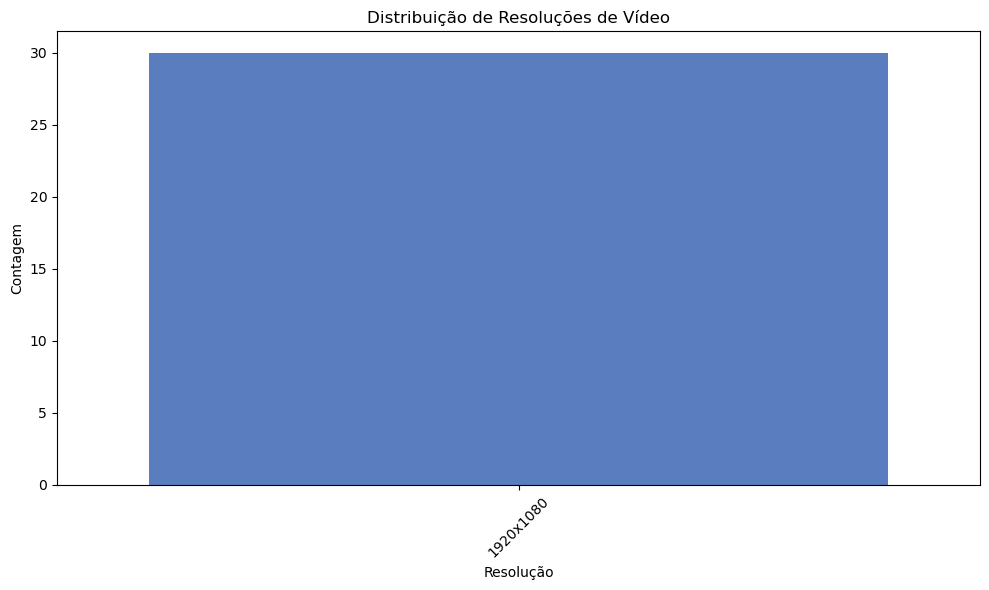

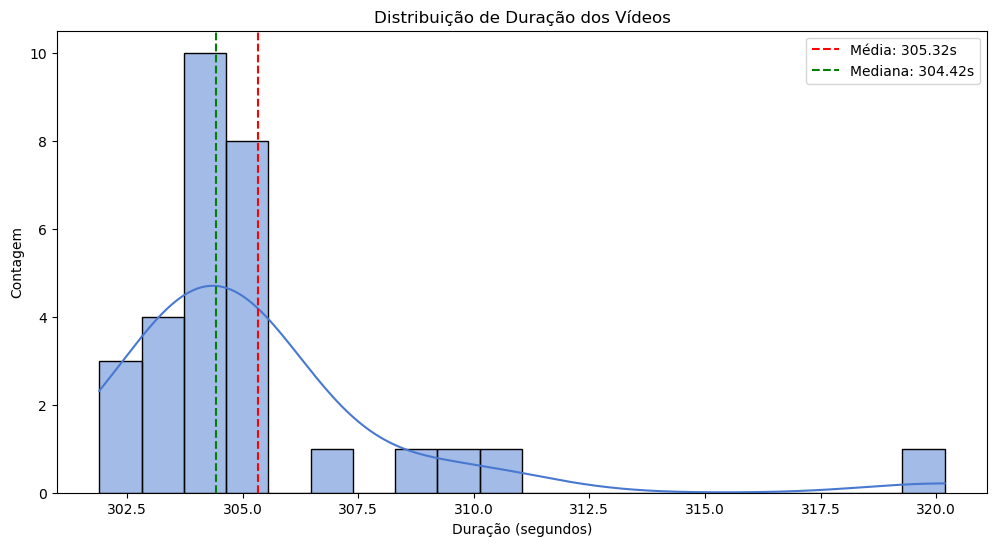

Estatísticas de duração (segundos):
count     30.000000
mean     305.323904
std        3.406496
min      301.901598
25%      303.978672
50%      304.420781
75%      305.321683
max      320.186526
Name: duration_sec, dtype: float64


In [3]:
resolution_counts = stats_df['resolution'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=resolution_counts.index, y=resolution_counts.values)
plt.title('Distribuição de Resoluções de Vídeo')
plt.xlabel('Resolução')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(stats_df['duration_sec'], bins=20, kde=True)
plt.title('Distribuição de Duração dos Vídeos')
plt.xlabel('Duração (segundos)')
plt.ylabel('Contagem')
plt.axvline(stats_df['duration_sec'].mean(), color='r', linestyle='--', label=f'Média: {stats_df["duration_sec"].mean():.2f}s')
plt.axvline(stats_df['duration_sec'].median(), color='g', linestyle='--', label=f'Mediana: {stats_df["duration_sec"].median():.2f}s')
plt.legend()
plt.show()

duration_stats = stats_df['duration_sec'].describe()
print("Estatísticas de duração (segundos):")
print(duration_stats)

## 3. Análise de FPS e Tamanho de Arquivo

Vamos analisar a distribuição de FPS e tamanhos de arquivo.

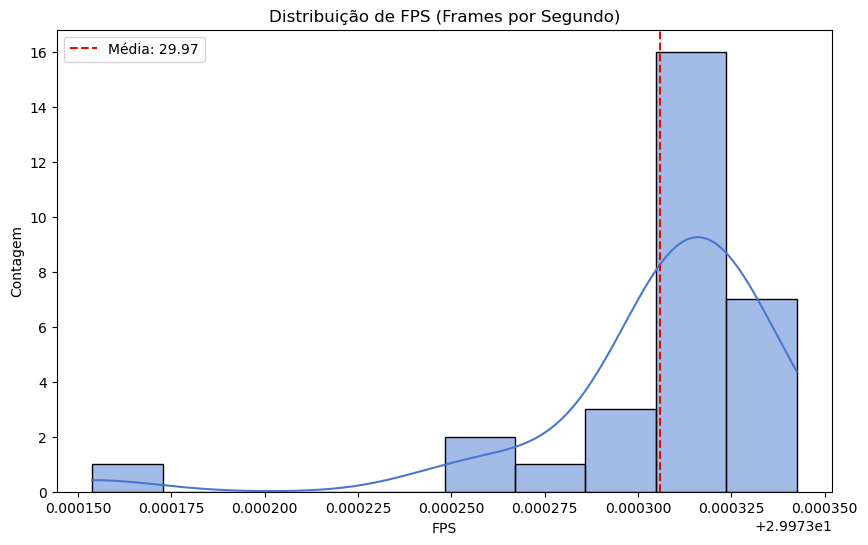

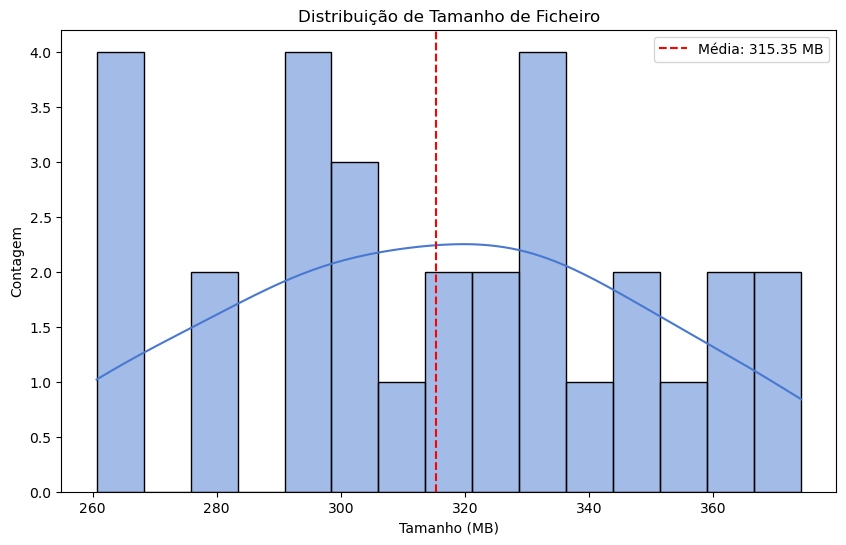

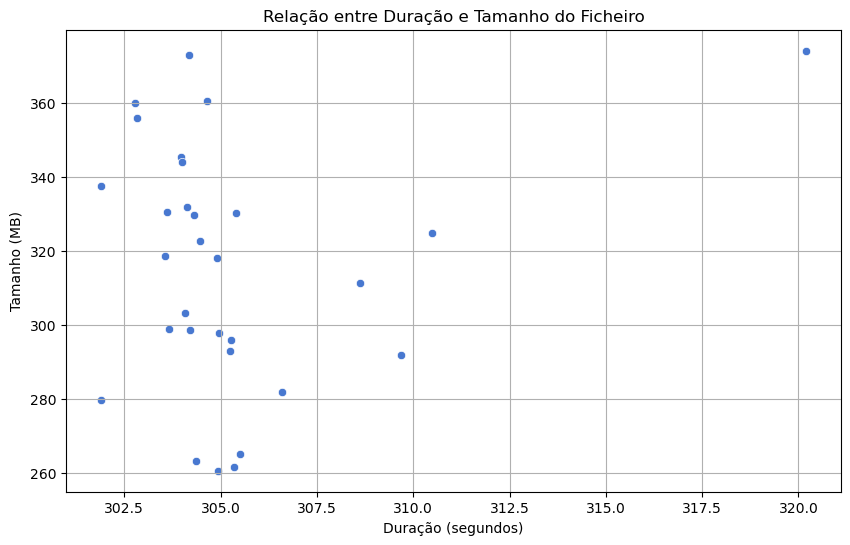

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(stats_df['fps'], bins=10, kde=True)
plt.title('Distribuição de FPS (Frames por Segundo)')
plt.xlabel('FPS')
plt.ylabel('Contagem')
plt.axvline(stats_df['fps'].mean(), color='r', linestyle='--', label=f'Média: {stats_df["fps"].mean():.2f}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(stats_df['file_size_mb'], bins=15, kde=True)
plt.title('Distribuição de Tamanho de Ficheiro')
plt.xlabel('Tamanho (MB)')
plt.ylabel('Contagem')
plt.axvline(stats_df['file_size_mb'].mean(), color='r', linestyle='--', label=f'Média: {stats_df["file_size_mb"].mean():.2f} MB')
plt.legend()
plt.show()

# Relação entre duração e tamanho
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_sec', y='file_size_mb', data=stats_df)
plt.title('Relação entre Duração e Tamanho do Ficheiro')
plt.xlabel('Duração (segundos)')
plt.ylabel('Tamanho (MB)')
plt.grid(True)
plt.show()

## 4. Análise de Brilho e Contraste

Vamos analisar as características visuais dos vídeos, como brilho e contraste.

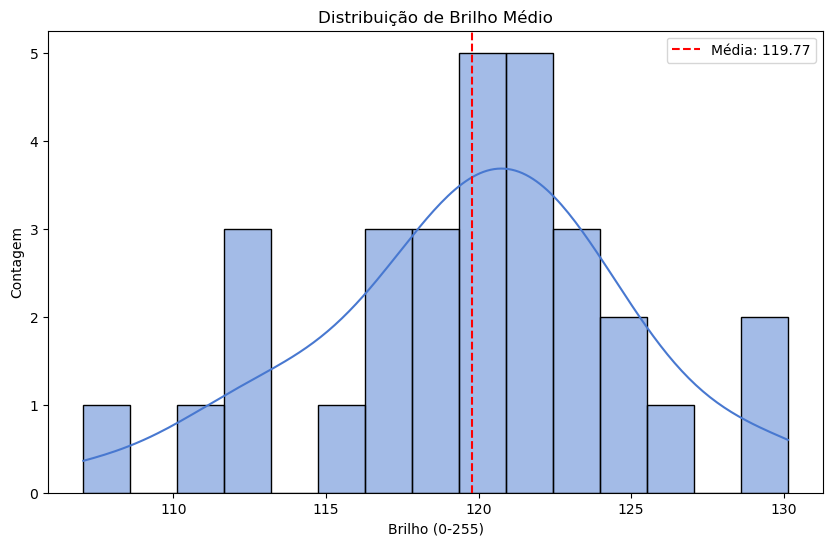

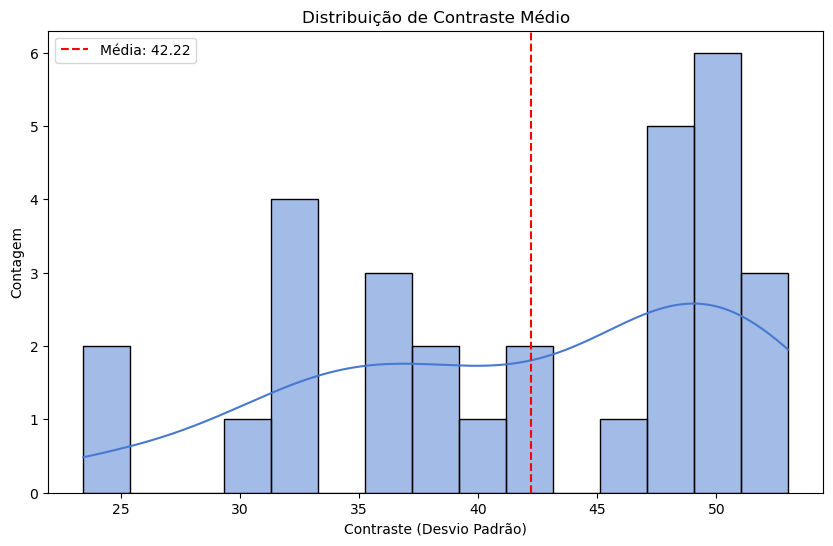

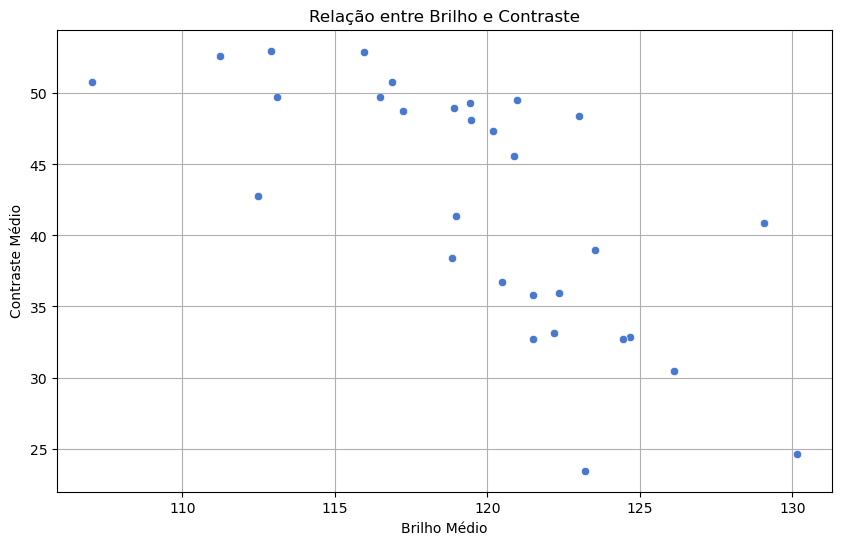

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(stats_df['avg_brightness'], bins=15, kde=True)
plt.title('Distribuição de Brilho Médio')
plt.xlabel('Brilho (0-255)')
plt.ylabel('Contagem')
plt.axvline(stats_df['avg_brightness'].mean(), color='r', linestyle='--', label=f'Média: {stats_df["avg_brightness"].mean():.2f}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(stats_df['avg_contrast'], bins=15, kde=True)
plt.title('Distribuição de Contraste Médio')
plt.xlabel('Contraste (Desvio Padrão)')
plt.ylabel('Contagem')
plt.axvline(stats_df['avg_contrast'].mean(), color='r', linestyle='--', label=f'Média: {stats_df["avg_contrast"].mean():.2f}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_brightness', y='avg_contrast', data=stats_df)
plt.title('Relação entre Brilho e Contraste')
plt.xlabel('Brilho Médio')
plt.ylabel('Contraste Médio')
plt.grid(True)
plt.show()

## 5. Identificação de Outliers

Vamos identificar vídeos com características atípicas que podem requerer tratamento especial.

Outliers de duração: 6
Outliers de FPS: 6
Outliers de tamanho: 0
Outliers de brilho: 1
Outliers de contraste: 0

Detalhes dos outliers de duração:
    filename  duration_sec  frame_count        fps
10  C42I.mp4    301.901598         9049  29.973343
21  A59Z.mp4    301.901598         9049  29.973343
27  C58C.mp4    308.608294         9250  29.973271
23  C48S.mp4    309.676026         9282  29.973260
11  C56Y.mp4    310.476830         9306  29.973251
0   A88O.mp4    320.186526         9597  29.973154


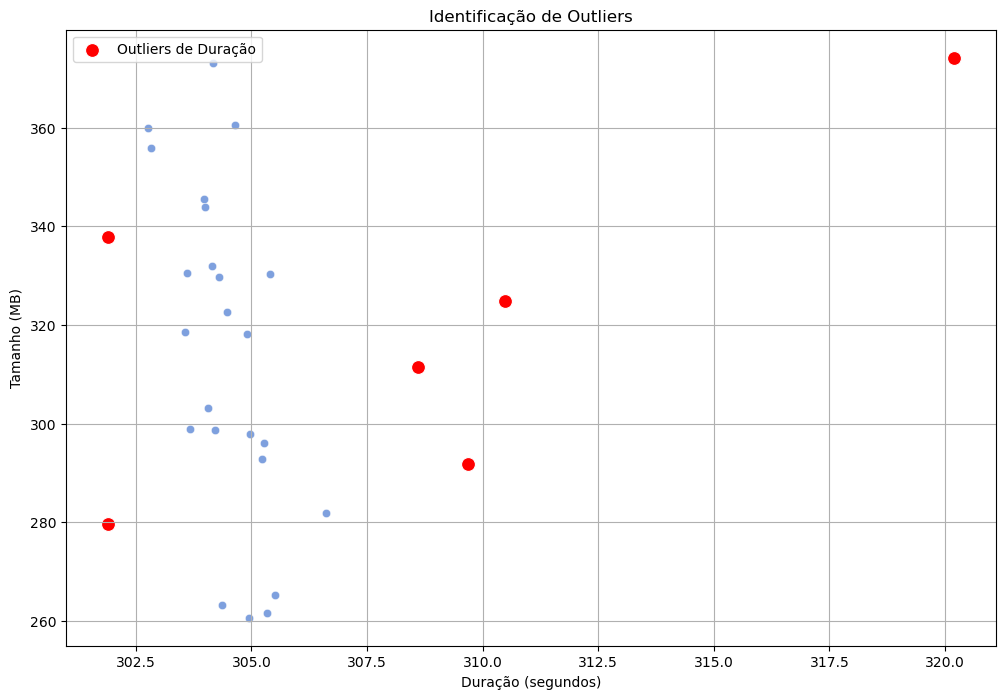

In [6]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

duration_outliers = identify_outliers(stats_df, 'duration_sec')
fps_outliers = identify_outliers(stats_df, 'fps')
size_outliers = identify_outliers(stats_df, 'file_size_mb')
brightness_outliers = identify_outliers(stats_df, 'avg_brightness')
contrast_outliers = identify_outliers(stats_df, 'avg_contrast')

print(f"Outliers de duração: {len(duration_outliers)}")
print(f"Outliers de FPS: {len(fps_outliers)}")
print(f"Outliers de tamanho: {len(size_outliers)}")
print(f"Outliers de brilho: {len(brightness_outliers)}")
print(f"Outliers de contraste: {len(contrast_outliers)}")

if not duration_outliers.empty:
    print("\nDetalhes dos outliers de duração:")
    print(duration_outliers[['filename', 'duration_sec', 'frame_count', 'fps']].sort_values('duration_sec'))

plt.figure(figsize=(12, 8))
sns.scatterplot(x='duration_sec', y='file_size_mb', data=stats_df, alpha=0.7)
sns.scatterplot(x='duration_sec', y='file_size_mb', data=duration_outliers, color='red', s=100, label='Outliers de Duração')
sns.scatterplot(x='duration_sec', y='file_size_mb', data=size_outliers, color='green', s=100, label='Outliers de Tamanho')
plt.title('Identificação de Outliers')
plt.xlabel('Duração (segundos)')
plt.ylabel('Tamanho (MB)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Análise de Correlação

Vamos analisar as correlações entre as diferentes características dos vídeos.

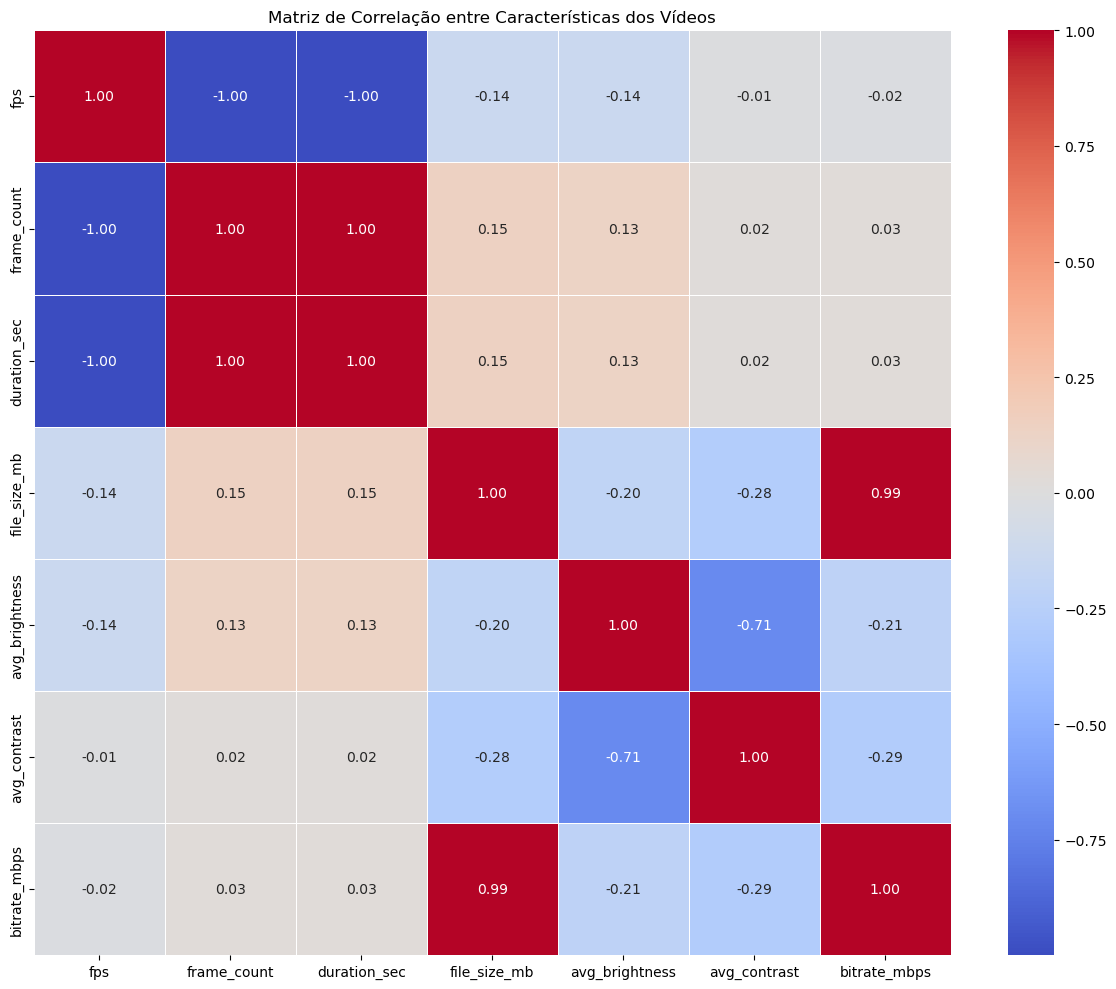

Top 5 pares de características com maior correlação:
frame_count e duration_sec: 1.0000
fps e duration_sec: 0.9998
fps e frame_count: 0.9998
file_size_mb e bitrate_mbps: 0.9933
avg_brightness e avg_contrast: 0.7058


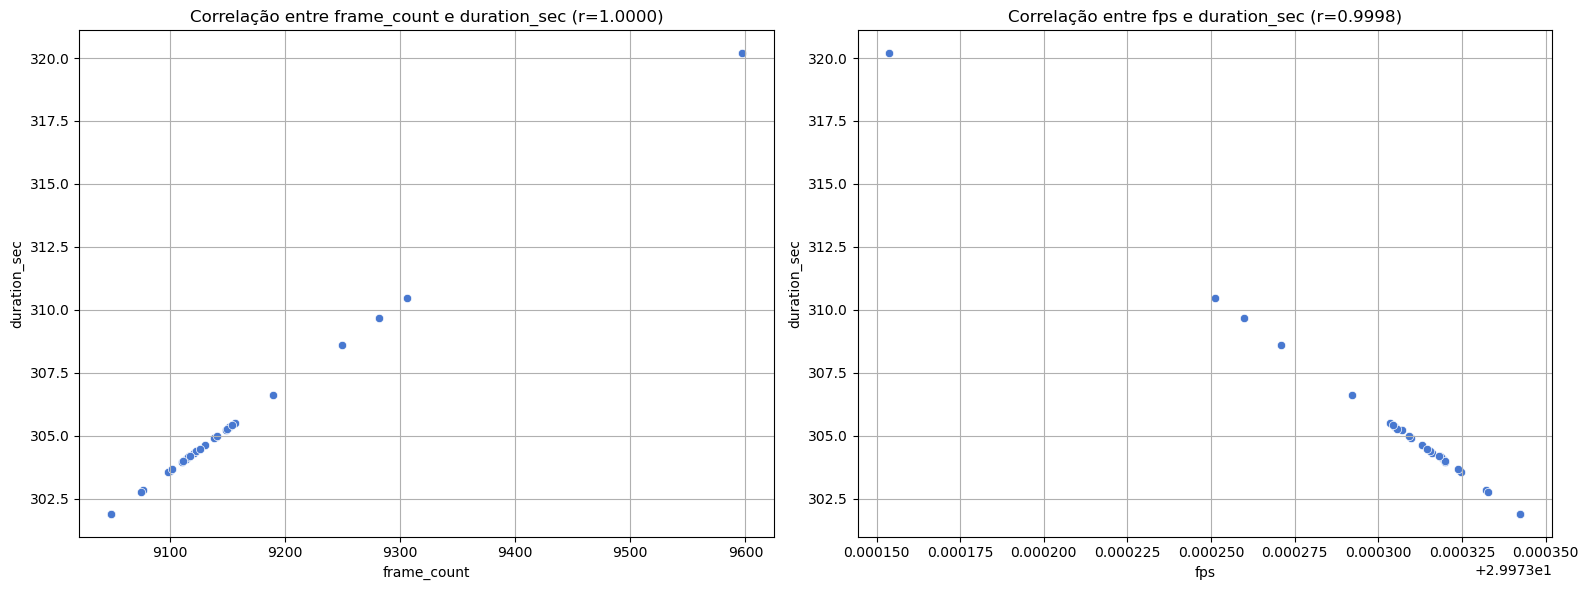

In [7]:
numeric_cols = ['fps', 'frame_count', 'duration_sec', 'file_size_mb', 
                'avg_brightness', 'avg_contrast', 'bitrate_mbps']
corr_df = stats_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Características dos Vídeos')
plt.tight_layout()
plt.show()

# Análise de pares de características com maior correlação - Encontrar os pares com maior correlação absoluta
corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_pairs.append((numeric_cols[i], numeric_cols[j], abs(corr_df.iloc[i, j])))

corr_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 5 pares de características com maior correlação:")
for pair in corr_pairs[:5]:
    print(f"{pair[0]} e {pair[1]}: {pair[2]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (col1, col2, corr) in enumerate(corr_pairs[:2]):
    sns.scatterplot(x=col1, y=col2, data=stats_df, ax=axes[i])
    axes[i].set_title(f'Correlação entre {col1} e {col2} (r={corr:.4f})')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [8]:
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)
stats_df.to_csv(f'{output_dir}/video_statistics.csv', index=False)
print(f"Estatísticas guardadas em '{output_dir}/video_statistics.csv'")

Estatísticas guardadas em '../data/video_statistics.csv'
